# Source Detection and Extraction #
Here, we will detect and extract sources from the CEERS NIRcam data for both cropped regions 1 and 2.
We will do this process using the python package SEP: https://sep.readthedocs.io/en/v1.0.x/index.html.
The goal of this notebook is to use the PSF-matched cropped regions from the CEERS NIRcam data to detect sources and create a 90x90 pixel cutout of each source that can be fed to a machine learning architecture to learn features from.

In [3]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sep
from matplotlib.patches import Ellipse
import warnings

warnings.filterwarnings('ignore')

First, we create a list of the set of filters and the input images, which, in this case, will be the results from the PSF-matching from the Crop_PSF_Match notebook. 

In [4]:
# List of the filters
filters = ['F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W']

# Number of filters
nbands = len(filters)

# Image files
fits_files = ['psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits',
              'psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits',
              'psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f200w_dr0.5_i2d.fits',
              'psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f277w_dr0.5_i2d.fits',
              'psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f356w_dr0.5_i2d.fits',
              'crop1_hlsp_ceers_jwst_nircam_nircam1_f444w_dr0.5_i2d.fits']

# Variance files
var_files = ['psfmatch_crop1_var_hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits',
             'psfmatch_crop1_var_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits',
             'psfmatch_crop1_var_hlsp_ceers_jwst_nircam_nircam1_f200w_dr0.5_i2d.fits',
             'psfmatch_crop1_var_hlsp_ceers_jwst_nircam_nircam1_f277w_dr0.5_i2d.fits',
             'psfmatch_crop1_var_hlsp_ceers_jwst_nircam_nircam1_f356w_dr0.5_i2d.fits',
             'crop1_var_hlsp_ceers_jwst_nircam_nircam1_f444w_dr0.5_i2d.fits']

# Pixel scale of the images
pixsize = .03

### Source Detection and Extraction ###
We will use SEP to detect sources and get segmentation maps from them. 
For this example, we will base the detection and extraction on the F150W band.

In [5]:
# Get image data
hdu = fits.open('psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits')
data_img = hdu[0].data
hdu.close()

data_img = data_img.byteswap(inplace=True).newbyteorder()

# Get variance image
hdu = fits.open('psfmatch_crop1_var_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits')
data_var = hdu[0].data
hdu.close()

data_var = data_var.byteswap(inplace=True).newbyteorder()
data_err = np.sqrt(data_var)

objects, segmap = sep.extract(data_img, thresh=2.0, err=data_err, minarea=5,
                              deblend_nthresh=32, deblend_cont=.005, segmentation_map=True)

Get the number of detected objects for this waveband.

In [6]:
# Get the number of detected objects
n_obj = len(objects) 
print(n_obj)

180


Show the detected objects using matplotlib's Ellipse function to create a red ellipse around each detected source.

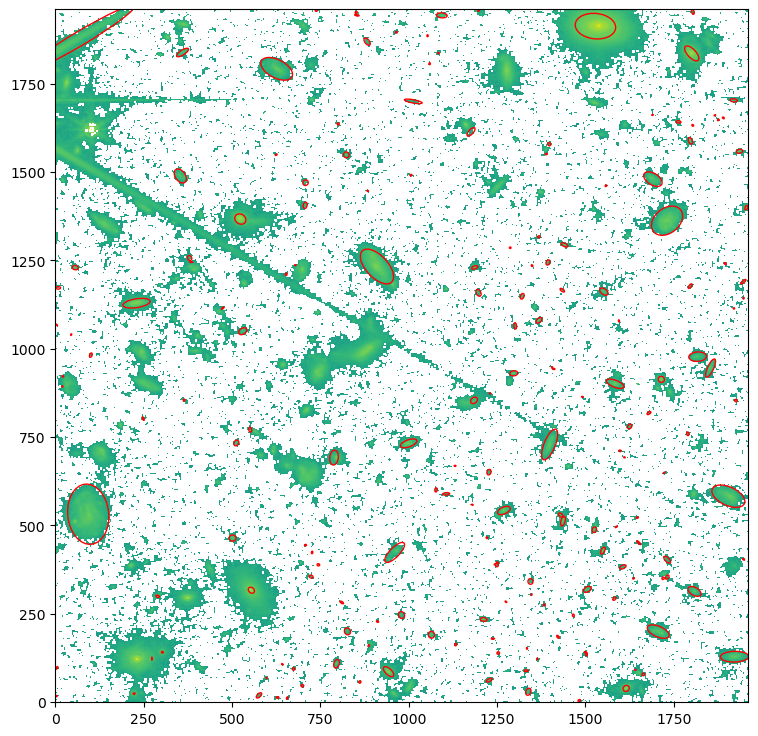

In [ ]:
# Plot the background-subtracted image
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(np.log10(data_img), origin='lower')

# plot an ellipse for each detected object
for i in range(n_obj):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

#### Show the Segmentation Map ####
A segmentation map is map showing the classification of pixels. 
Pixels that belong to the same object will have the same value and this value denotes the index of the object in the SEP catalog. 

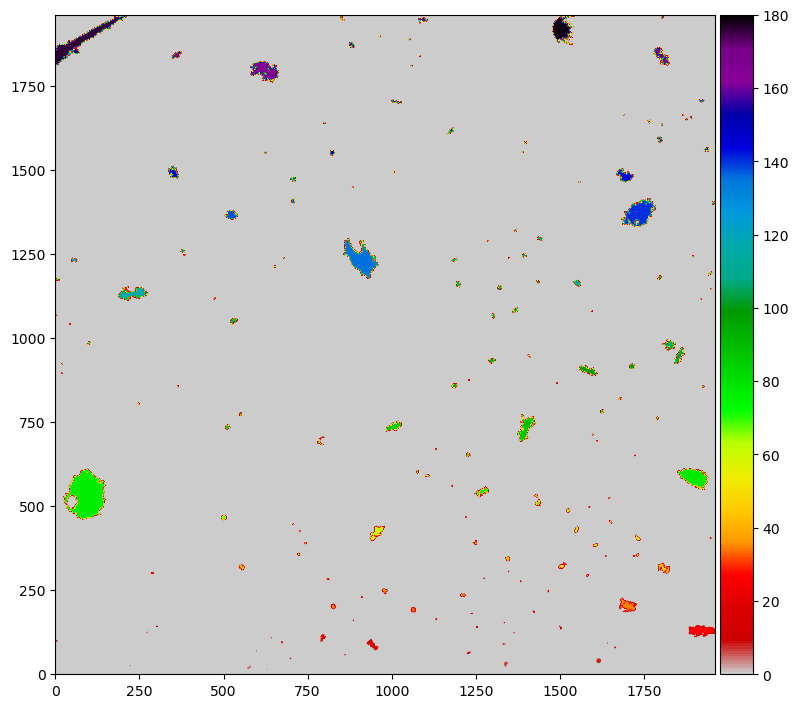

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9,9))
f = plt.subplot()

# Plot the segmentation map
im = plt.imshow(segmap, origin='lower', cmap='nipy_spectral_r')
divider = make_axes_locatable(f)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### Aperture Photometry ###
We use aperture photometry to get the SED's (Spectral Energy Distributions) of the detected objects.
The Spectral Energy Distribution gives the flux measured at multiple bands. In photometry, the SED can be regarded as a spectrum with a very low spectral resolution. For further information, see: https://www.sciencedirect.com/topics/physics-and-astronomy/spectral-energy-distribution.

We will compute aperture photometry based on a circular aperture with a radius of 10 pixels (0.03 arcsec in an image with 0.03 arcsec/pixel).

In [9]:
# Circular aperture radius
aper_radius = 10.0 # corresponds to 0.03 arcsec in pixels

flux0 = np.zeros((nbands, n_obj))
fluxerr0 = np.zeros((nbands,n_obj))
flag0 = np.zeros((nbands,n_obj))
for i in range(0, nbands):
    # Get image data
    hdu = fits.open(fits_files[i])
    data_img = hdu[0].data
    hdu.close()
    
    data_img = data_img.byteswap(inplace=True).newbyteorder()
    
    # Get variance image data
    hdu = fits.open(var_files[i])
    data_var = hdu[0].data
    hdu.close()
    
    data_var = data_var.byteswap(inplace=True).newbyteorder()
    data_err = np.sqrt(data_var)
    
    flux0[i], fluxerr0[i], flag0[i] = sep.sum_circle(data_img, objects['x'], objects['y'],
                                                     aper_radius, err=data_err, gain=1.0)
    
    # change nan or inf
    idx_change = np.where(np.isnan(flux0[i])==True)
    flux0[i][idx_change[0]] = -99.0
    
    idx_change = np.where(np.isnan(fluxerr0[i])==True)
    fluxerr0[i][idx_change[0]] = -99.0

Transpose the fluxes from (band-id, object-id) to (object-id, band-id). 

In [10]:
flux = np.transpose(flux0, axes=(1,0))
fluxerr = np.transpose(fluxerr0, axes=(1,0))
flag = np.transpose(flag0, axes=(1,0))

Create an astropy Qtable to store the id, x- and y-coordinates and fluxes of the detected sources. 

In [11]:
from astropy.table import QTable

idx = np.arange(n_obj)
data_table = []
names = []
# Get ID for each object
data_table.append(idx)
names.append('ID')
# Get x- and y-coordinates
data_table.append(objects['x'])
names.append('x')
data_table.append(objects['y'])
names.append('y')
for i in range(0, nbands):
    # Get fluxes for each object
    data_table.append(flux0[i])
    names.append('f_%s' % filters[i])
    data_table.append(fluxerr0[i])
    names.append('fe_%s' % filters[i]) # fe for error

names = tuple(names)
t = QTable(data_table, names=names, meta={'name': 'catalog'}) 

print(t)

 ID         x          ...       f_F444W             fe_F444W     
--- ------------------ ... ------------------- -------------------
  0  1482.351356646871 ...  0.9628108387233805  0.9891454578116989
  1  656.0325278645205 ...  0.6147441378451729  0.7897885767266422
  2  628.5056928053026 ...  1.1156751317724403  1.0650481935020797
  3  2.997346829956311 ... 0.04755081464361865 0.25206380128893535
  4  576.1303799304437 ...  2.7337202364630264  1.6659292689392695
  5 222.66401563799332 ...   58.05707445561886   8.909948718706685
  6 1338.2656333439522 ...  1.5267278188868658  1.2440555520433243
...                ... ...                 ...                 ...
173 1093.4502491598034 ...                 0.0                 0.0
174  851.0741090859957 ...                 0.0                 0.0
175  68.42032616365651 ...  3.2575611061160457  1.8202672979588126
176 1196.9746924106669 ...                 0.0                 0.0
177 1528.1787326914173 ...   692.1838365983964   60.0215426493

To produce cutouts of each detected source, we will need the centre coordinates of each object. We store these coordinates in a list called *coords*.

In [12]:
# initialise a 'coordinates' list
coords = []   
xcoords = []
ycoords = []
for i in range(len(t)):
    x_coord = t['x'][i]
    y_coord = t['y'][i]
    xcoords.append(x_coord)
    ycoords.append(y_coord)
for j in range(len(xcoords)):
    coords.append((xcoords[j],ycoords[j]))

To create a catalog of source cutouts for each waveband, we will use astropy's Cutout2D to create a 90x90 pixel cutout. Each waveband cutout is saved.
To create a cutout for each waveband, change the hdu filename to the desired waveband.

In [13]:
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

# Filename to write out the data to
filename = 'cutout.fits'

hdu = fits.open('psfmatch_crop1_hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits')[0]
wcs = WCS(hdu.header)

# create a cutout for each object within the coords list
for j in range(0, len(coords)-1):
    x_centre, y_centre = coords[j]
    position = (x_centre, y_centre)
    crop_size = (90,90)
    cutout = Cutout2D(hdu.data, position=position, size=crop_size, wcs=wcs,
                      mode="partial", fill_value=0)
    name_out = str(j)+'galaxy_%s' % filename
    fits.writeto(name_out, cutout.data, cutout.wcs.to_header(), overwrite=True)
    print("[produce %s]" % name_out) 

[produce 0galaxy_cutout.fits]
[produce 1galaxy_cutout.fits]
[produce 2galaxy_cutout.fits]
[produce 3galaxy_cutout.fits]
[produce 4galaxy_cutout.fits]
[produce 5galaxy_cutout.fits]
[produce 6galaxy_cutout.fits]
[produce 7galaxy_cutout.fits]
[produce 8galaxy_cutout.fits]
[produce 9galaxy_cutout.fits]
[produce 10galaxy_cutout.fits]
[produce 11galaxy_cutout.fits]
[produce 12galaxy_cutout.fits]
[produce 13galaxy_cutout.fits]
[produce 14galaxy_cutout.fits]
[produce 15galaxy_cutout.fits]
[produce 16galaxy_cutout.fits]
[produce 17galaxy_cutout.fits]
[produce 18galaxy_cutout.fits]
[produce 19galaxy_cutout.fits]
[produce 20galaxy_cutout.fits]
[produce 21galaxy_cutout.fits]
[produce 22galaxy_cutout.fits]
[produce 23galaxy_cutout.fits]
[produce 24galaxy_cutout.fits]
[produce 25galaxy_cutout.fits]
[produce 26galaxy_cutout.fits]
[produce 27galaxy_cutout.fits]
[produce 28galaxy_cutout.fits]
[produce 29galaxy_cutout.fits]
[produce 30galaxy_cutout.fits]
[produce 31galaxy_cutout.fits]
[produce 32galaxy_

### Cropped Region 2 ###
We now repeat the above steps for cropped region 2.

In [14]:
# Image files for cropped region 2
fits_files_2 = ['psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits',
              'psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits',
              'psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f200w_dr0.5_i2d.fits',
              'psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f277w_dr0.5_i2d.fits',
              'psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f356w_dr0.5_i2d.fits',
              'crop2_hlsp_ceers_jwst_nircam_nircam1_f444w_dr0.5_i2d.fits']

# Variance files for cropped region 2
var_files_2 = ['psfmatch_crop2_var_hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits',
             'psfmatch_crop2_var_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits',
             'psfmatch_crop2_var_hlsp_ceers_jwst_nircam_nircam1_f200w_dr0.5_i2d.fits',
             'psfmatch_crop2_var_hlsp_ceers_jwst_nircam_nircam1_f277w_dr0.5_i2d.fits',
             'psfmatch_crop2_var_hlsp_ceers_jwst_nircam_nircam1_f356w_dr0.5_i2d.fits',
             'crop2_var_hlsp_ceers_jwst_nircam_nircam1_f444w_dr0.5_i2d.fits']

In [15]:
# Get image data
hdu = fits.open('psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits')
data_img_2 = hdu[0].data
hdu.close()

data_img_2 = data_img_2.byteswap(inplace=True).newbyteorder()

# Get variance image
hdu = fits.open('psfmatch_crop2_var_hlsp_ceers_jwst_nircam_nircam1_f150w_dr0.5_i2d.fits')
data_var_2 = hdu[0].data
hdu.close()

data_var_2 = data_var_2.byteswap(inplace=True).newbyteorder()
data_err_2 = np.sqrt(data_var_2)

objects_2, segmap_2 = sep.extract(data_img_2, thresh=2.0, err=data_err_2, minarea=5,
                              deblend_nthresh=32, deblend_cont=.005, segmentation_map=True)

In [16]:
nobj = len(objects_2)
print(nobj)

285


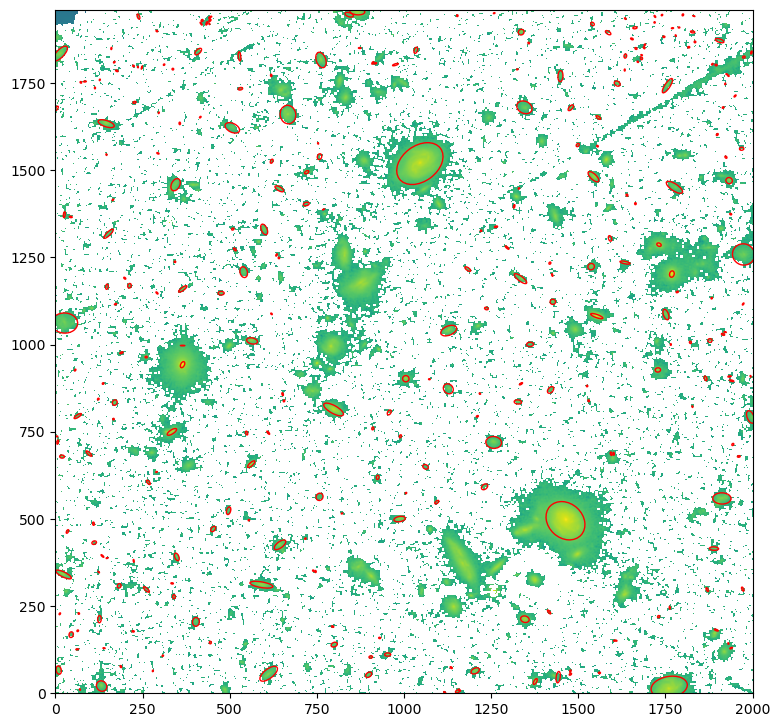

In [17]:
# Plot the background-subtracted image
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(np.log10(data_img_2), origin='lower')

# plot an ellipse for each detected object
for i in range(nobj):
    e = Ellipse(xy=(objects_2['x'][i], objects_2['y'][i]),
                width=6*objects_2['a'][i],
                height=6*objects_2['b'][i],
                angle=objects_2['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

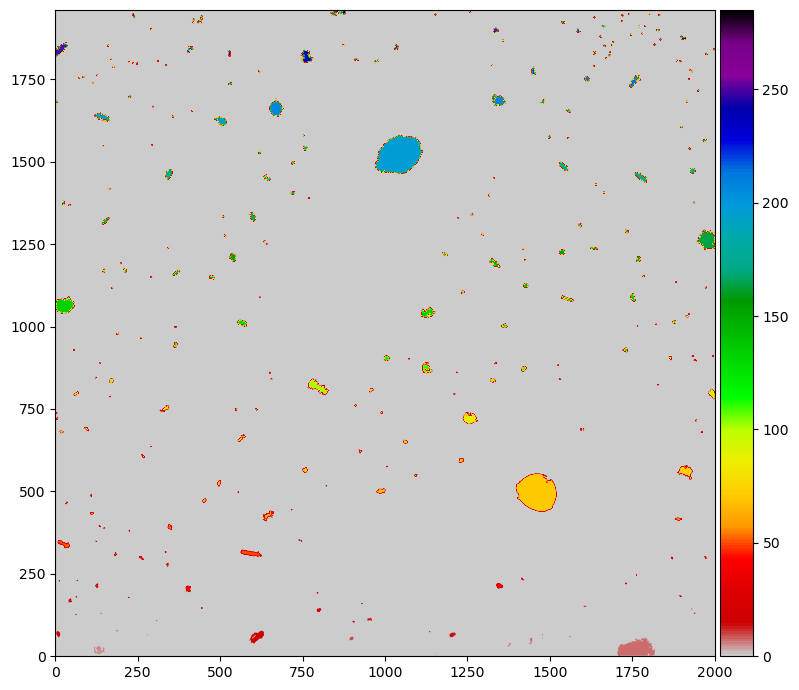

In [18]:
# Show the segmentation map for cropped region 2
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9,9))
f = plt.subplot()

im = plt.imshow(segmap_2, origin='lower', cmap='nipy_spectral_r')
divider = make_axes_locatable(f)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

Perform aperature photometry for cropped region 2 in the same way as above.

In [19]:
# Circular aperture radius
aper_radius = 10.0 # corresponds to 0.03 arcsec in pixels

flux0_2 = np.zeros((nbands, nobj))
fluxerr0_2 = np.zeros((nbands,nobj))
flag0_2 = np.zeros((nbands,nobj))
for i in range(0, nbands):
    # Get image data for cropped region 2
    hdu = fits.open(fits_files_2[i])
    data_img_2 = hdu[0].data
    hdu.close()
    
    data_img_2 = data_img_2.byteswap(inplace=True).newbyteorder()
    
    # Get variance image data for cropped region 2
    hdu = fits.open(var_files_2[i])
    data_var_2 = hdu[0].data
    hdu.close()
    
    data_var_2 = data_var_2.byteswap(inplace=True).newbyteorder()
    data_err_2 = np.sqrt(data_var_2)
    
    flux0_2[i], fluxerr0_2[i], flag0_2[i] = sep.sum_circle(data_img_2, objects_2['x'],
                                                           objects_2['y'], aper_radius, 
                                                           err=data_err_2, gain=1.0)
    
    # change nan or inf
    idx_change = np.where(np.isnan(flux0_2[i])==True)
    flux0_2[i][idx_change[0]] = -99.0
    
    idx_change = np.where(np.isnan(fluxerr0_2[i])==True)
    fluxerr0_2[i][idx_change[0]] = -99.0

Transpose the fluxes.

In [20]:
flux2 = np.transpose(flux0_2, axes=(1,0))
fluxerr2 = np.transpose(fluxerr0_2, axes=(1,0))
flag2 = np.transpose(flag0_2, axes=(1,0))

Create an astropy Qtable for cropped region 2.

In [21]:
from astropy.table import QTable

idx = np.arange(nobj)
data_table = []
names = []

# Get ID for each object
data_table.append(idx)
names.append('ID')
# Get x- and y-coordinates
data_table.append(objects_2['x'])
names.append('x')
data_table.append(objects_2['y'])
names.append('y')
for i in range(0, nbands):
    # Get fluxes for each object
    data_table.append(flux0_2[i])
    names.append('f_%s' % filters[i])
    data_table.append(fluxerr0_2[i])
    names.append('fe_%s' % filters[i]) # fe for error

names = tuple(names)
t = QTable(data_table, names=names, meta={'name': 'catalog'}) 

print(t)

 ID         x          ...        f_F444W              fe_F444W      
--- ------------------ ... --------------------- --------------------
  0 1116.8067918562067 ...   0.41500720244293915   0.6484020401817308
  1 1153.6504567584013 ...     3.060051836366474   1.7683799595522656
  2 1159.3542694697337 ...    2.6974650804325924   1.6613464905010873
  3  70.58869463251803 ...   0.23941797564307313   0.4946346695763111
  4 132.54568670187703 ...    20.826086488552388   4.7912770162593175
  5 1376.7066175082052 ...     39.24622947927564    7.100960281885813
  6 1760.8882865829721 ...      423.446117209196     33.5444823310407
...                ... ...                   ...                  ...
278 1153.0054247621274 ...   0.04412974979146383  0.22879622575473654
279 238.24734248025894 ...    0.8287010398793793   0.9193438480146532
280 1740.1629304678129 ...   -0.3500387818957097  0.08710752786766084
281 1800.1039597789704 ...   0.11221670162165541  0.34763465300198804
282  842.84630118015

In [22]:
# initialise a 'coordinates' list
coords = []   
xcoords = []
ycoords = []

for i in range(len(t)):
    x_coord = t['x'][i]
    y_coord = t['y'][i]
    xcoords.append(x_coord)
    ycoords.append(y_coord)
    
for j in range(len(xcoords)):
    coords.append((xcoords[j],ycoords[j]))

Create 90x90 cutouts for each waveband in cropped region 2.

In [ ]:
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

# Filename to write out the data to
filename = 'cutout.fits'

hdu = fits.open('psfmatch_crop2_hlsp_ceers_jwst_nircam_nircam1_f115w_dr0.5_i2d.fits')[0]
wcs = WCS(hdu.header)

# create a cutout for each object within the coords list
for j in range(0, len(coords)-1):
    x_centre, y_centre = coords[j]
    position = (x_centre, y_centre)
    crop_size = (90,90)
    cutout = Cutout2D(hdu.data, position=position, size=crop_size, wcs=wcs,
                      mode="partial", fill_value=0)
    name_out = str(j)+'galaxy_%s' % filename
    fits.writeto(name_out, cutout.data, cutout.wcs.to_header(), overwrite=True)
    print("[produce %s]" % name_out) 